In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D,GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import os
os.chdir('./4-2/')
import kt_utils

from keras import backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow


Using TensorFlow backend.


In [2]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = kt_utils.load_dataset()

In [8]:
X_train = train_set_x_orig / 255.
X_test = test_set_x_orig / 255.
Y_train = train_set_y_orig.T
Y_test = test_set_y_orig.T
print(f'X_train.shape = {X_train.shape}')
print(f'Y_train.shape = {Y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'Y_test.shape = {Y_test.shape}')

X_train.shape = (600, 64, 64, 3)
Y_train.shape = (600, 1)
X_test.shape = (150, 64, 64, 3)
Y_test.shape = (150, 1)


In [11]:
def HappyModel(input_shape):

    '''
    描述处理单个数据的方法
    input_shape - single data shape
    '''
    
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2, 2), name='max_pool')(X)

    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    model = Model(inputs=X_input, outputs=X, name='HappyModel')

    return model

In [12]:
happy_model = HappyModel(X_train.shape[1:])
happy_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
happy_model.fit(X_train, Y_train, epochs=40, batch_size=50)
preds = happy_model.evaluate(X_test, Y_test, batch_size=32)
print(f'误差值 = {preds[0]}')
print(f'准确度 = {preds[1]}')









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/40
600/600 [==============================] - 8s 14ms/step - loss: 3.3841 - acc: 0.4833
Epoch 2/40
600/600 [==============================] - 8s 13ms/step - loss: 0.9763 - acc: 0.7033
Epoch 3/40
600/600 [==============================] - 8s 13ms/step - loss: 0.5903 - acc: 0.7950
Epoch 4/40
600/600 [==============================] - 7s 12ms/step - loss: 0.2383 - acc: 0.8933
Epoch 5/40
600/600 [==============================] - 7s 12ms/step - loss: 0.1771 - acc: 0.9283
Epoch 6/40
600/600 [==============================] - 7s 12ms/step - loss: 0.1340 - acc: 0.9500
Epoch 7/40
600/600 [==============================] - 7s 12ms/step - loss: 0.1342 - acc: 0.9483
Epoch 8/40
600/600 [==============================] - 7s 12ms/step - loss: 0.1056 - acc: 0.9750
Epoch 9/40
600/600 [==============================] - 7s 12ms/step - loss: 0.0988 - acc: 0.9700
Epoch 10/40
600/600 [=============

In [13]:
happy_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
__________

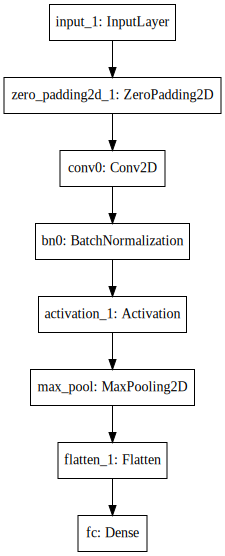

In [14]:
plot_model(happy_model, to_file='happy_model.png')
SVG(model_to_dot(happy_model).create(prog='dot', format='svg'))